# Individual Event Data Pull + Save

#### Import packages

In [1]:
import env_methods as em
import vis_methods as vm

import copy
import numpy as np
import pandas as pd
import os 

#### Get reanalysis data and generate z-scores

In [2]:
sst_dir = r'D:\NOAA Reanalysis Data\SST'
atmo_dir = r'D:\NOAA Reanalysis Data\Atmo Monthly Means'

air_package = em.get_data(atmo_dir, True, 0)
sst_package = em.get_data(sst_dir, True, 0)

s_sst_package = copy.deepcopy(sst_package)
s_sst_package['nc_vars']['sst'] = em.normalize_data(np.flip(s_sst_package['nc_vars']['sst']), s_sst_package['time'])

s_air_package = copy.deepcopy(air_package) #deep copy required due to nested elements 

for p in s_air_package['level']:
    p = s_air_package['level'].index(p)
    var = s_air_package['nc_vars']['hgt'][:, p, :, :]
    var = em.normalize_data(var, s_air_package['time'])
    s_air_package['nc_vars']['hgt'][:, p, :, :] = var

acquring data from air.mon.mean.nc
acquring data from hgt.mon.mean.nc
acquring data from uwnd.mon.mean.nc
acquring data from vwnd.mon.mean.nc
acquring data from sst.mnmean.nc


C:\Users\bydd1\Anaconda3\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\bydd1\Anaconda3\lib\site-packages\numpy\core\_methods.py:183: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\env_methods.py:133: RuntimeWarning: invalid value encountered in true_divide
  stdev_monthly[month - 1])


#### Import top flood dates from excel file

In [3]:
riv_path = r'D:\Data\river data\USGS\top_ten.csv' 
riv_dates = pd.read_csv(riv_path)
riv_dates = riv_dates[:5]
for loc in riv_dates.keys():
    riv_dates[loc] = pd.to_datetime(riv_dates[loc], format = "%m/%d/%Y") #convert to dt object
riv_dates

hermann louisville  vicksburg
0 1993-07-31 1937-01-26 2011-05-17
1 1903-06-07 1945-03-07 1927-05-01
2 1951-07-19 1884-02-16 1937-02-17
3 1995-05-19 1964-03-12 1973-05-12
4 1944-04-28 1913-04-02 1945-04-08

#### Save 3 month prior data for each flood event into file

C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\vis_methods.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (12,4))
C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\vis_methods.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (12,4))
C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\vis_methods.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

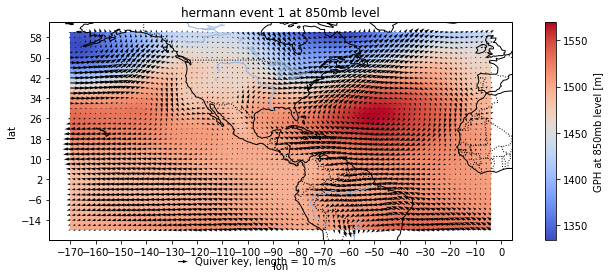

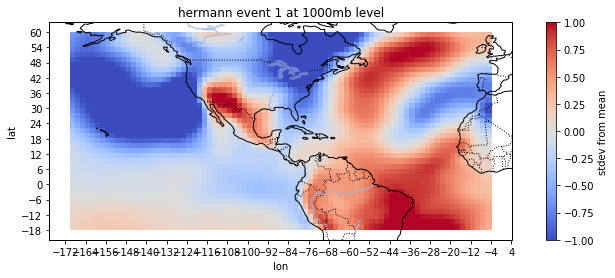

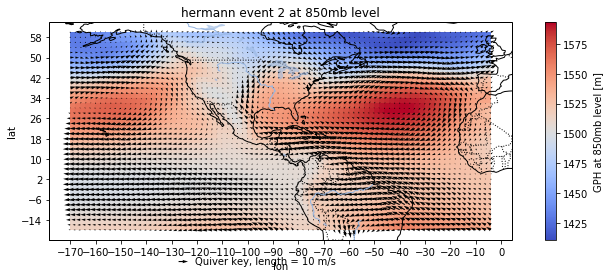

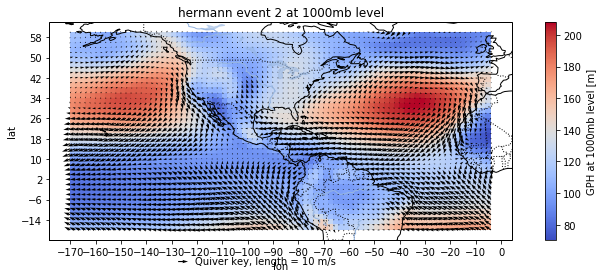

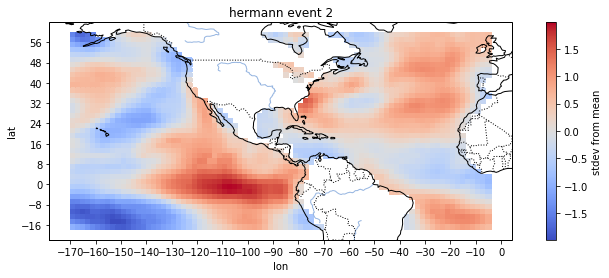

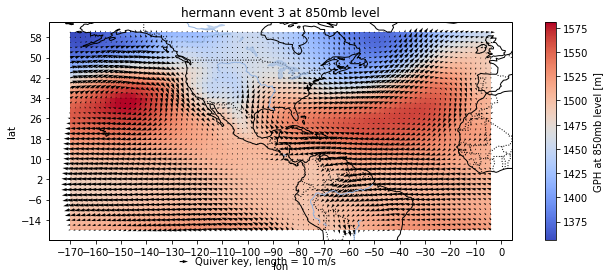

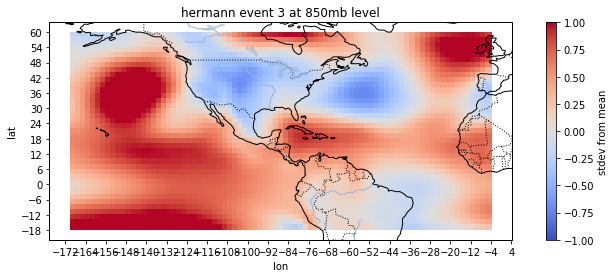

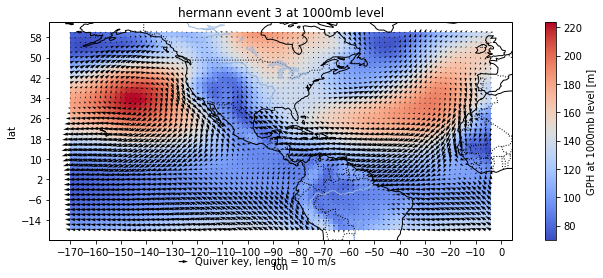

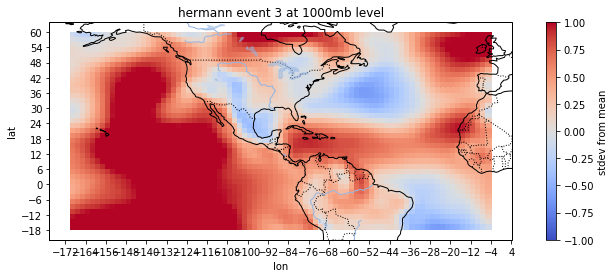

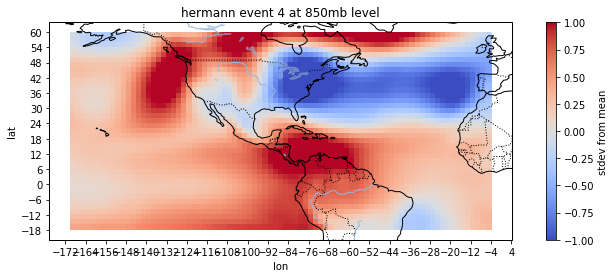

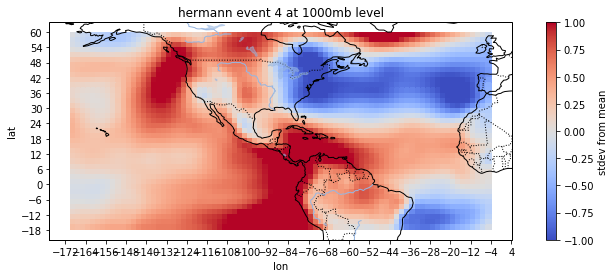

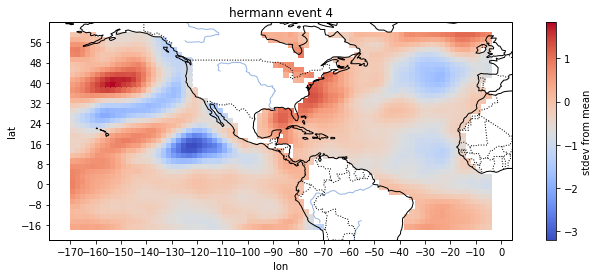

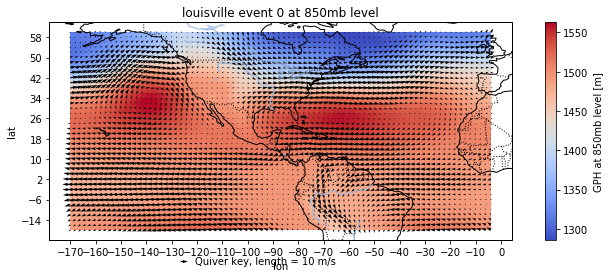

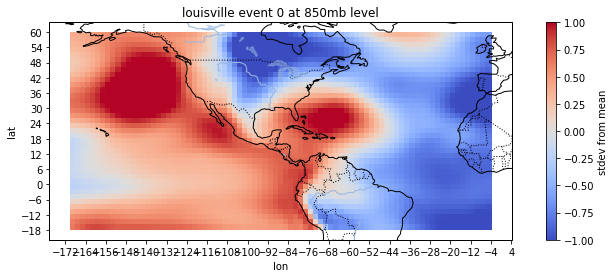

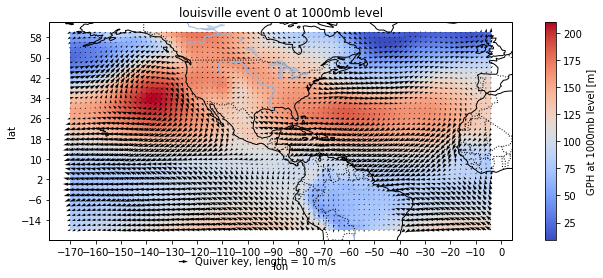

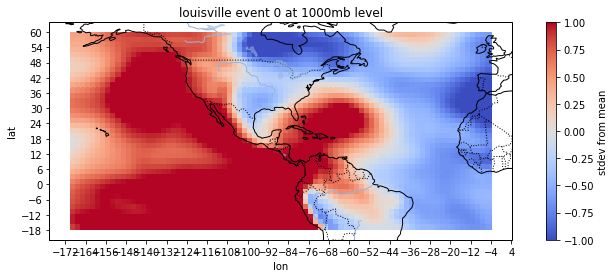

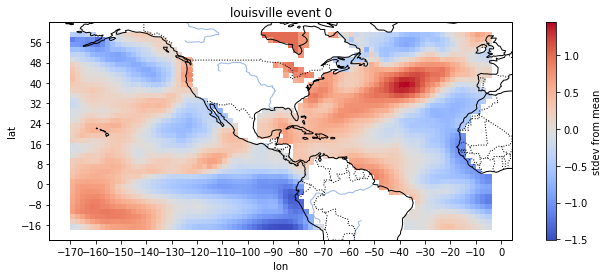

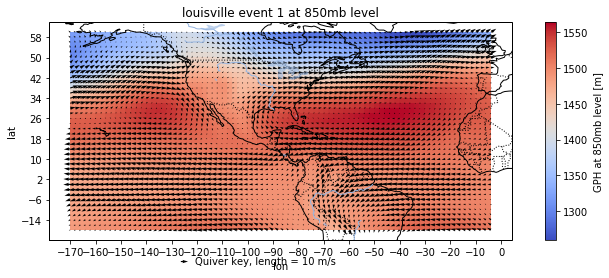

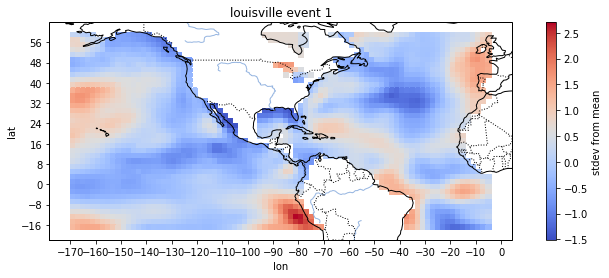

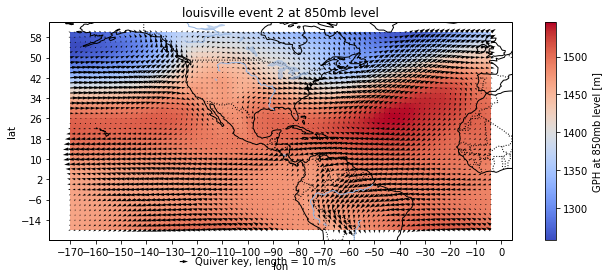

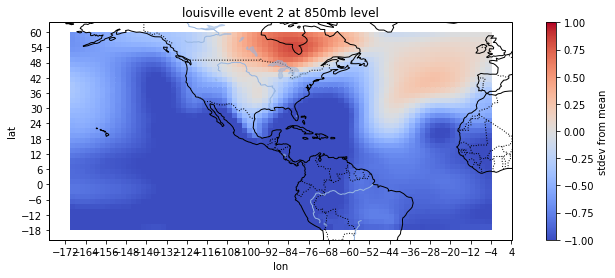

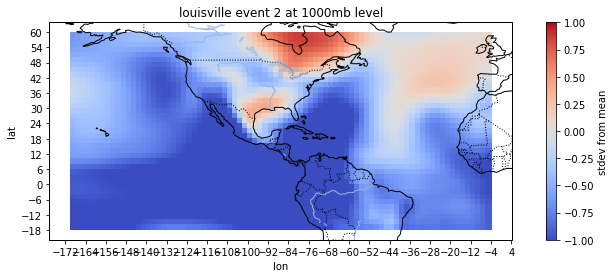

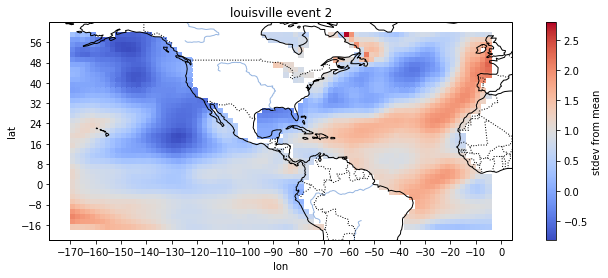

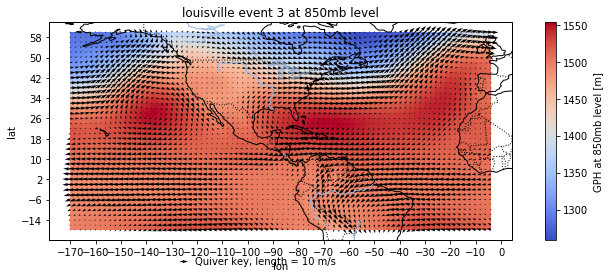

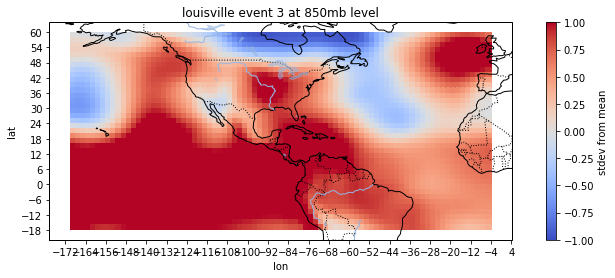

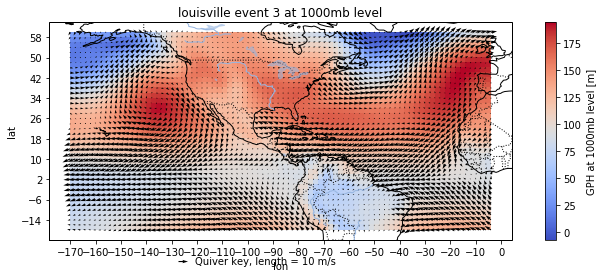

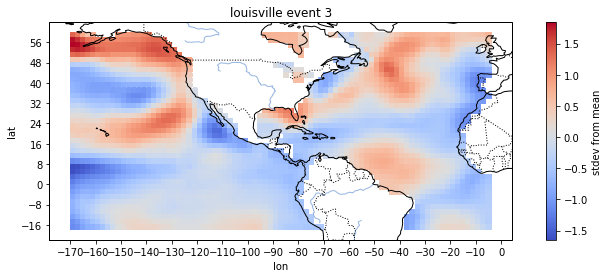

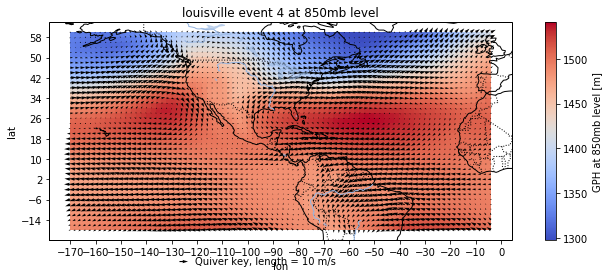

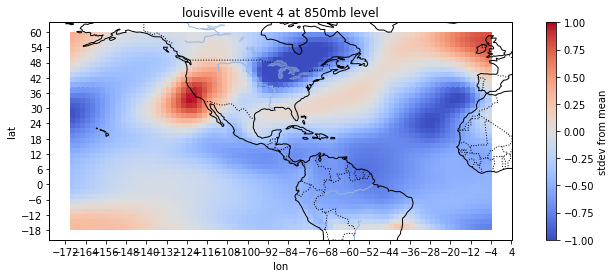

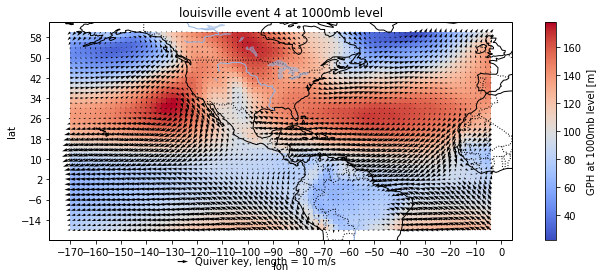

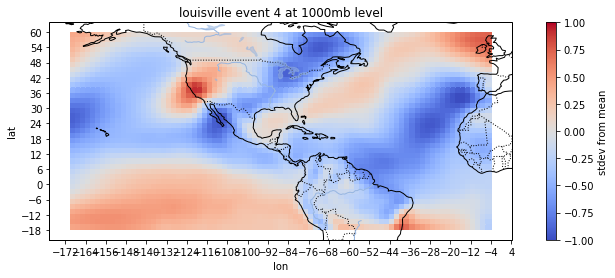

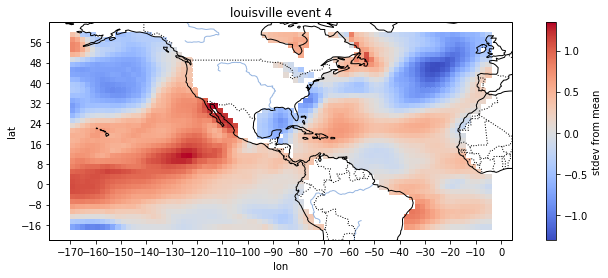

In [4]:
save_dir = r'C:\Users\bydd1\OneDrive\Documents\Research\Powerpoints\miss_basin_atmo_trend_pictures\ind_events'

loc_int = ['hermann', 'louisville']
p_int = [850, 1000]

lat_start = 60
lat_end = -20
lon_start = 360 - 170
lon_end = 360 - 0

for loc in loc_int:
    for date in riv_dates[loc]:
       
        air_ind = em.find_closest_val(date, air_package['time'])
        sst_ind = em.find_closest_val(date, sst_package['time'])
        
        temp_air = copy.deepcopy(air_package)
        s_temp_air = copy.deepcopy(s_air_package)
        for var in temp_air['nc_vars']:
            temp_air['nc_vars'][var] = np.mean(temp_air['nc_vars'][var][air_ind - 3: air_ind + 1], axis = 0)
            s_temp_air['nc_vars'][var] = np.mean(s_temp_air['nc_vars'][var][air_ind - 3: air_ind + 1], axis = 0)
            
        temp_sst = copy.deepcopy(sst_package)
        s_temp_sst = copy.deepcopy(s_sst_package)
        temp_sst['nc_vars']['sst'] = np.flip(np.mean(temp_sst['nc_vars']['sst'][air_ind - 3: air_ind + 1], axis = 0 ))
        s_temp_sst['nc_vars']['sst'] = np.flip(np.mean(s_temp_sst['nc_vars']['sst'][air_ind - 3: air_ind + 1], axis = 0))
                                               
        for p in p_int:

            event_index = riv_dates[loc].tolist().index(date)
            title = loc + ' event ' + str(event_index) + ' at ' + str(p) + 'mb level'
            f = vm.average_plot(lat_start, lat_end, lon_start, lon_end, air_package['lat'], air_package['lon'], 
                    temp_air['level'], p, temp_air['nc_vars'], title )
                                
            f.savefig(os.path.join(save_dir, loc,  str(event_index) + 'comp_' + str(p) + 'mb.png'))
            
            f = vm.height_anomaly_plot(lat_start, lat_end, lon_start, lon_end, air_package['lat'], air_package['lon'], 
                    temp_air['level'], p, s_temp_air['nc_vars'], title )
            
            f.savefig(os.path.join(save_dir, loc,  str(event_index) + 'anomaly_' + str(p) + 'mb.png'))
        
        title = loc + ' event ' + str(event_index) 
        f = vm.sst_anomaly_plot(lat_start, lat_end, lon_start, lon_end, s_temp_sst['lat'], s_temp_sst['lon'], s_temp_sst['nc_vars'], title, False)
        
        f.savefig(os.path.join(save_dir, loc,  str(event_index) + 'anomaly_sst.png'))

In [5]:
temp_air['nc_vars']['hgt'].shape

(3, 91, 180)